In [1]:
import pandas as pd
import numpy as np
import ROOT

input_directory ='/lustre/isaac/scratch/tmengel/jet-background-subtraction/datasets'
collens = ['200GeV','2760GeV']
jetradii = ['R02','R04','R06']
data_sets = [f"{input_directory}/{collen}/{jetradius}/{collen}_Match_{jetradius}.root" for collen in collens for jetradius in jetradii]
ds = ["AuAu_R02", "AuAu_R04", "AuAu_R06", "PbPb_R02", "PbPb_R04", "PbPb_R06"]    
output_directory = '/lustre/isaac/scratch/tmengel/jet-background-subtraction/results/multiplictyestimate'
outfiles = [f"{output_directory}/{d}.h5" for d in ds]

In [24]:
for dsname, dsfile in zip(ds, data_sets):
    ROOT.ROOT.EnableImplicitMT()
    df = ROOT.RDataFrame("tree", dsfile)
    
    min_raw_pt = df.Min("jet_pt_raw").GetValue()+10.0
    max_raw_pt = df.Max("jet_pt_raw").GetValue()
    
    min_pt = 10.0
    max_pt = df.Max("jet_pt_truth").GetValue()
    
    min_nparts_pythia = df.Min("jet_nparts_pythia").GetValue()
    max_nparts_pythia = df.Max("jet_nparts_pythia").GetValue()
    
    if max_raw_pt > 200:
        max_raw_pt = 200
    if max_pt > 200:
        max_pt = 200
        
    if dsname.startswith("AuAu"):
        max_pt = 90
        max_raw_pt = 90
        print("AuAu")

    nbins_nparts_pythia = int(max_nparts_pythia - min_nparts_pythia)
    th2d_raw = df.Histo2D(("raw", "raw",100, min_raw_pt, max_raw_pt, nbins_nparts_pythia, min_nparts_pythia, max_nparts_pythia), 'jet_pt_raw', 'jet_nparts_pythia').GetPtr()
    th2d_truth = df.Histo2D(("truth", "truth",100, min_pt, max_pt, nbins_nparts_pythia, min_nparts_pythia, max_nparts_pythia,), 'jet_pt_truth', 'jet_nparts_pythia').GetPtr()
    
    tprofile_raw = th2d_raw.ProfileX()  
    tprofile_truth = th2d_truth.ProfileX()
    
    
    nparts_vs_pt_raw_mean = np.array([tprofile_raw.GetBinContent(i) for i in range(1, tprofile_raw.GetNbinsX()+1)])
    nparts_vs_pt_raw_mean_err = np.array([tprofile_raw.GetBinError(i) for i in range(1, tprofile_raw.GetNbinsX()+1)])
    nparts_vs_pt_truth_mean = np.array([tprofile_truth.GetBinContent(i) for i in range(1, tprofile_truth.GetNbinsX()+1)])
    nparts_vs_pt_truth_mean_err = np.array([tprofile_truth.GetBinError(i) for i in range(1, tprofile_truth.GetNbinsX()+1)])
    x = np.array([tprofile_raw.GetBinCenter(i) for i in range(1, tprofile_raw.GetNbinsX()+1)])
    x_err = np.array([tprofile_raw.GetBinWidth(i)/2 for i in range(1, tprofile_raw.GetNbinsX()+1)])
    
    results = pd.DataFrame({"nparts": x, "nparts_err": x_err, "nparts_vs_pt_raw_mean": nparts_vs_pt_raw_mean, "nparts_vs_pt_raw_mean_err": nparts_vs_pt_raw_mean_err, "nparts_vs_pt_truth_mean": nparts_vs_pt_truth_mean, "nparts_vs_pt_truth_mean_err": nparts_vs_pt_truth_mean_err}) 
    results.to_hdf(outfiles[ds.index(dsname)], key="df", mode="w")
    
    print(f"Finished {dsname}")    
    
ds_for_comparison = ["PbPb_R02", "PbPb_R04", "PbPb_R06"]
data_sets_for_comparison = data_sets[3:]
outfiles_for_comparison = outfiles = [f"{output_directory}/{d}_datacomp.h5" for d in ds_for_comparison]
for dsname, dsfile in zip(ds_for_comparison, data_sets_for_comparison):
    ROOT.ROOT.EnableImplicitMT()
    df = ROOT.RDataFrame("tree", dsfile)
    
    min_raw_pt = 10.0
    max_raw_pt = 100.0
    max_nparts_pythia = df.Max("jet_nparts_pythia").GetValue()
    min_nparts_pythia = df.Min("jet_nparts_pythia").GetValue()
    
    nbins = 9
    nbins_nparts_pythia = int(max_nparts_pythia - min_nparts_pythia)
    th2d_raw = df.Histo2D(("raw", "raw",nbins, min_raw_pt, max_raw_pt, nbins_nparts_pythia, min_nparts_pythia, max_nparts_pythia), 'jet_pt_raw', 'jet_nparts_pythia').GetPtr()
    
    tprofile_raw = th2d_raw.ProfileX()  
    
    
    nparts_vs_pt_raw_mean = np.array([tprofile_raw.GetBinContent(i) for i in range(1, tprofile_raw.GetNbinsX()+1)])
    nparts_vs_pt_raw_mean_err = np.array([tprofile_raw.GetBinError(i) for i in range(1, tprofile_raw.GetNbinsX()+1)])
    x = np.array([tprofile_raw.GetBinCenter(i) for i in range(1, tprofile_raw.GetNbinsX()+1)])
    x_err = np.array([tprofile_raw.GetBinWidth(i)/2 for i in range(1, tprofile_raw.GetNbinsX()+1)])
    
    results = pd.DataFrame({"nparts": x, "nparts_err": x_err, "nparts_vs_pt_raw_mean": nparts_vs_pt_raw_mean, "nparts_vs_pt_raw_mean_err": nparts_vs_pt_raw_mean_err}) 
    results.to_hdf(outfiles_for_comparison[ds_for_comparison.index(dsname)], key="df", mode="w")
    
    print(f"Finished {dsname}")  

AuAu
Finished AuAu_R02
AuAu
Finished AuAu_R04
AuAu
Finished AuAu_R06
Finished PbPb_R02
Finished PbPb_R04
Finished PbPb_R06


In [25]:
mult = {}
for dsname, outfile in zip(ds,outfiles):
    df = pd.read_hdf(outfile)
    tmpmult = {}
    tmpmult["raw"] = df["nparts_vs_pt_raw_mean"].values
    tmpmult["raw_err"] = df["nparts_vs_pt_raw_mean_err"].values
    tmpmult["truth"] = df["nparts_vs_pt_truth_mean"].values
    tmpmult["truth_err"] = df["nparts_vs_pt_truth_mean_err"].values
    tmpmult['nparts'] = df['nparts'].values
    tmpmult['nparts_err'] = df['nparts_err'].values
    mult[dsname] = tmpmult
    
mult_datacomp = {}
for dsname, outfile in zip(ds_for_comparison,outfiles_for_comparison):
    df = pd.read_hdf(outfile)
    tmpmult = {}
    tmpmult["raw"] = df["nparts_vs_pt_raw_mean"].values
    tmpmult["raw_err"] = df["nparts_vs_pt_raw_mean_err"].values
    tmpmult['nparts'] = df['nparts'].values
    tmpmult['nparts_err'] = df['nparts_err'].values
    mult_datacomp[dsname] = tmpmult

R02df = pd.read_csv('/lustre/isaac/scratch/tmengel/jet-background-subtraction/results/multiplictyestimate/R02.dat', sep='\t', header=None, names=['x','y','ysys','ystat'])
R02df = R02df[1:]
R04df = pd.read_csv('/lustre/isaac/scratch/tmengel/jet-background-subtraction/results/multiplictyestimate/R04.dat', sep='\t', header=None, names=['x','y','ysys','ystat'])
R04df = R04df[1:]
R06df = pd.read_csv('/lustre/isaac/scratch/tmengel/jet-background-subtraction/results/multiplictyestimate/R06.dat', sep='\t', header=None, names=['x','y','ysys','ystat'])
R06df = R06df[1:]

R02 = {}
R04 = {}
R06 = {}

for col in R02df.columns:
    R02[col] = R02df[col].values.astype(float)
for col in R04df.columns:
    R04[col] = R04df[col].values.astype(float)
for col in R06df.columns:
    R06[col] = R06df[col].values.astype(float)
    
R02['yerr'] = np.sqrt(R02['ysys']**2 + R02['ystat']**2)
R04['yerr'] = np.sqrt(R04['ysys']**2 + R04['ystat']**2)
R06['yerr'] = np.sqrt(R06['ysys']**2 + R06['ystat']**2)

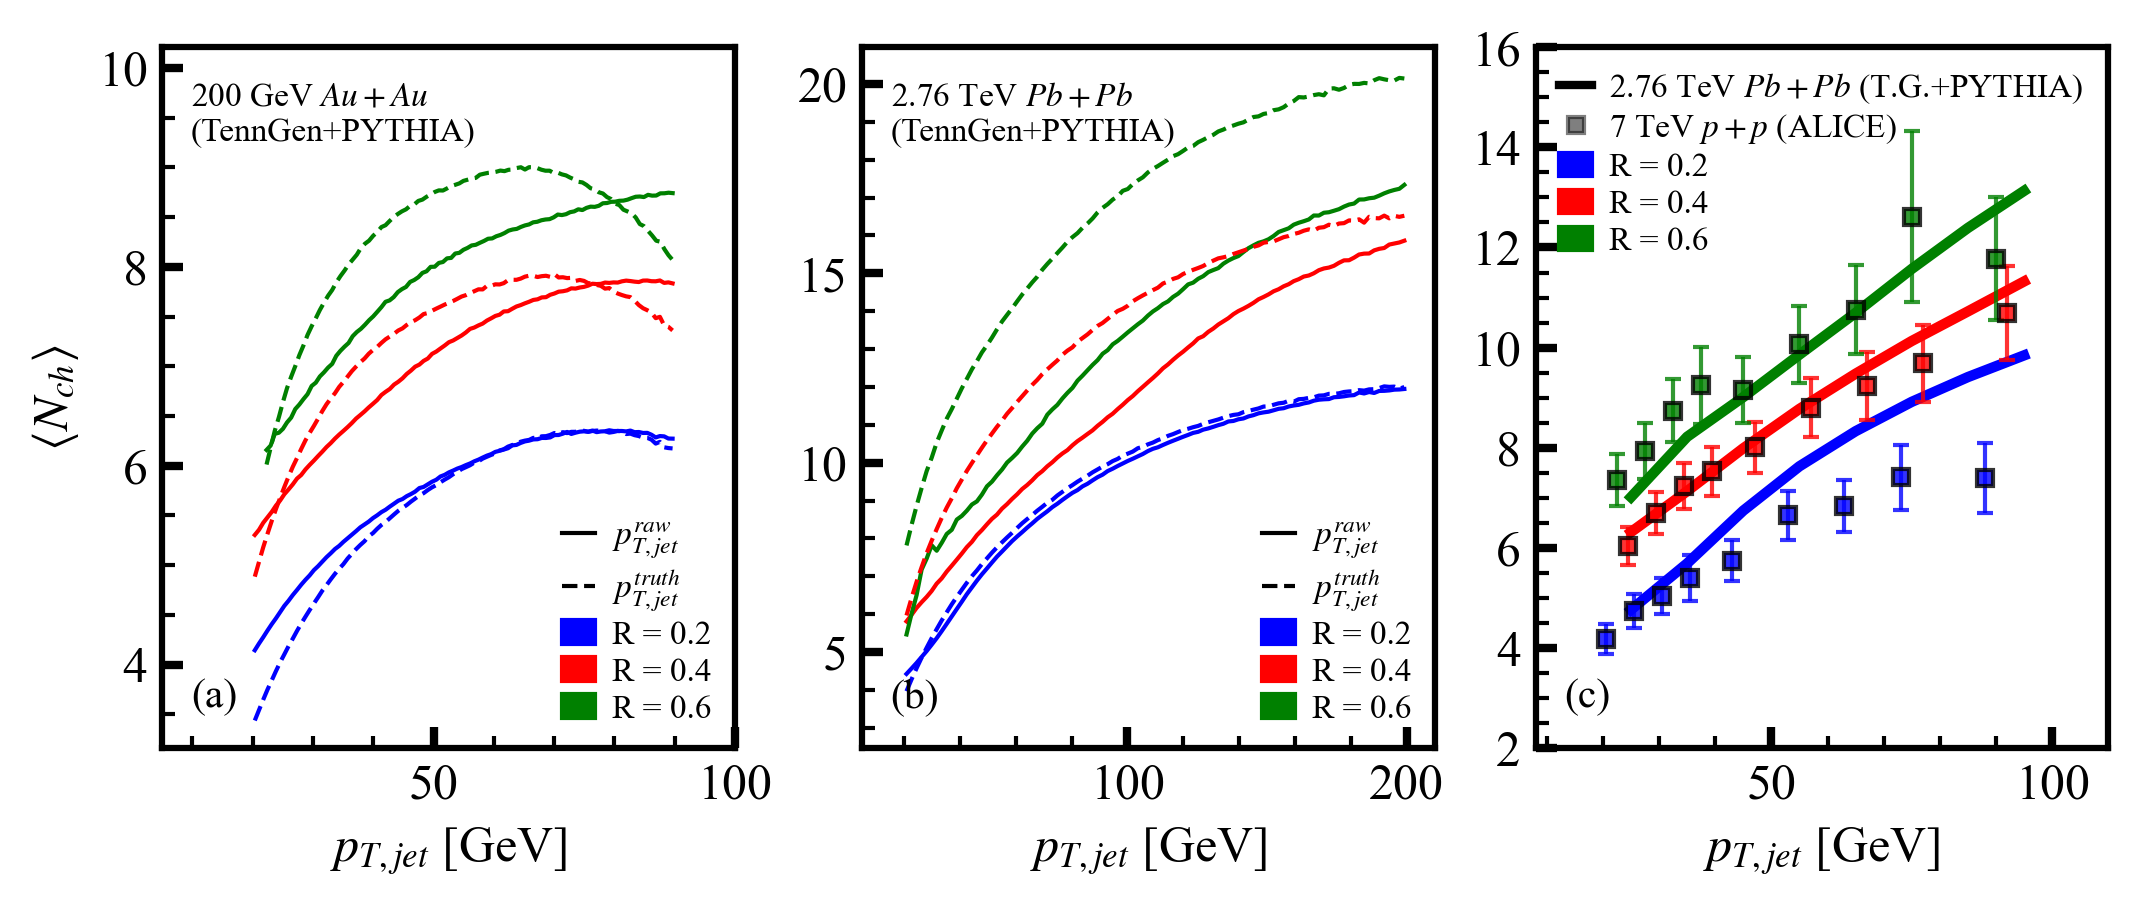

In [197]:
import paperstyle as ps
import matplotlib.pyplot as plt

fig_size = ps.GetFigSize(510.0, 3.0)
plt.rcParams.update(ps.style)
plt.rcParams.update({'figure.figsize': fig_size})
fig = plt.figure(dpi=300,constrained_layout=True)
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

dsauau = ["AuAu_R02", "AuAu_R04", "AuAu_R06"]
dspbpb = ["PbPb_R02", "PbPb_R04", "PbPb_R06"]
labels = ["R = 0.2", "R = 0.4", "R = 0.6"]
colors = ['blue', 'red', 'green']

# ax1.plot([], [], label=r'$p_{T,jet}^{raw}}$', linestyle='none', color='black')
for dsname in dsauau:
    ax1.plot(mult[dsname]['nparts'], mult[dsname]['raw'], label=labels[dsauau.index(dsname)], linestyle='-', color=colors[dsauau.index(dsname)])
# ax1.plot([], [], label=r'$p_{T,jet}^{truth}}$', linestyle='none', color='black')
for dsname in dsauau:
    ax1.plot(mult[dsname]['nparts'], mult[dsname]['truth'], label=labels[dsauau.index(dsname)], linestyle='--', color=colors[dsauau.index(dsname)])


# ax2.plot([], [], label=r'$p_{T,jet}^{raw}}$', linestyle='none', color='black')
for dsname in dspbpb:
    ax2.plot(mult[dsname]['nparts'], mult[dsname]['raw'], label=labels[dspbpb.index(dsname)], linestyle='-', color=colors[dspbpb.index(dsname)])
    
# ax2.plot([], [], label=r'$p_{T,jet}^{truth}}$', linestyle='none', color='black')
for dsname in dspbpb:
    ax2.plot(mult[dsname]['nparts'], mult[dsname]['truth'], label=labels[dspbpb.index(dsname)], linestyle='--', color=colors[dspbpb.index(dsname)])
    
# ax3.plot([], [], label=r'Pb+Pb 2.76 TennGen', linestyle='none', color='black')
for dsname in ds_for_comparison:
    ax3.plot(mult_datacomp[dsname]['nparts'][1:], mult_datacomp[dsname]['raw'][1:], label=labels[ds_for_comparison.index(dsname)], linestyle='-', color=colors[ds_for_comparison.index(dsname)],linewidth=2.5)
    

ax3.errorbar(R02['x']-2, R02['y'], yerr=R02['yerr'], label="R = 0.2", marker='s', linestyle='none', color='blue', markersize=4, alpha=0.8, markeredgecolor='black',ecolor='blue', capsize=2)
ax3.errorbar(R04['x']+2, R04['y'], yerr=R04['yerr'], label="R = 0.4", marker='s', linestyle='none', color='red', markersize=4, alpha=0.8, markeredgecolor='black',ecolor='red', capsize=2)
ax3.errorbar(R06['x'], R06['y'], yerr=R06['yerr'], label="R = 0.6", marker='s', linestyle='none', color='green', markersize=4, alpha=0.8, markeredgecolor='black',ecolor='green', capsize=2)
    
# ax3.plot(R02['x'], R02['y'], label="R = 0.2", marker='s', linestyle='none', color='blue', markersize=4, alpha=0.7, markeredgecolor='black')
# ax3.fill_between(R02['x'], R02['y']-R02['yerr'], R02['y']+R02['yerr'], alpha=0.1, color='blue', hatch='//' ,interpolate=True)
# ax3.plot(R04['x'], R04['y'], label="R = 0.4", marker='s', linestyle='none', color='red', markersize=4, alpha=0.7, markeredgecolor='black')
# ax3.fill_between(R04['x'], R04['y']-R04['yerr'], R04['y']+R04['yerr'], alpha=0.1, color='red', hatch='||',interpolate=True)
# ax3.plot(R06['x'], R06['y'], label="R = 0.6", marker='s', linestyle='none', color='green', markersize=4, alpha=0.7, markeredgecolor='black')   
# ax3.fill_between(R06['x'], R06['y']-R06['yerr'], R06['y']+R06['yerr'], alpha=0.1, color='green', hatch='..',interpolate=True)

ax1.set_ylabel(r"$\langle N_{ch} \rangle$")
ax1.set_xlabel(r"$p_{T,jet}$ [GeV]")
ax2.set_xlabel(r"$p_{T,jet}$ [GeV]")
ax1.set_xlim(5, 100)
ax1.set_ylim(ax1.get_ylim()[0], ax1.get_ylim()[1]*1.1)
ax2.set_ylim(ax2.get_ylim()[0]*0.78, ax2.get_ylim()[1])
ax2.set_xlim(5, 210)

import matplotlib.patches as mpatches
ax1.legend(loc='lower right', fontsize=8, frameon=False, 
           handles=[ax1.plot([], [], label=r'$p_{T,jet}^{raw}}$', linestyle='-', color='black')[0], 
                    ax1.plot([], [], label=r'$p_{T,jet}^{truth}}$', linestyle='--', color='black')[0],
                    mpatches.Patch(color='blue'), mpatches.Patch(color='red'), mpatches.Patch(color='green')],
            labels=[r'$p_{T,jet}^{raw}}$', r'$p_{T,jet}^{truth}}$','R = 0.2', 'R = 0.4', 'R = 0.6',],
            ncol=1, columnspacing=0.2, handletextpad=0.5, handlelength=1.0, borderpad=0.2, labelspacing=0.2)
ax1.text(0.05, 0.95, "200 GeV $Au+Au$", transform=ax1.transAxes, fontsize=8, verticalalignment='top')
ax1.text(0.05, 0.9, "(TennGen+PYTHIA)", transform=ax1.transAxes, fontsize=8, verticalalignment='top')

ax2.legend(loc='lower right', fontsize=8, frameon=False,
              handles=[ax2.plot([], [], label=r'$p_{T,jet}^{raw}}$', linestyle='-', color='black')[0],
                       ax2.plot([], [], label=r'$p_{T,jet}^{truth}}$', linestyle='--', color='black')[0],
                          mpatches.Patch(color='blue'), mpatches.Patch(color='red'), mpatches.Patch(color='green')],
              labels=[r'$p_{T,jet}^{raw}}$', r'$p_{T,jet}^{truth}}$','R = 0.2', 'R = 0.4', 'R = 0.6',],
                ncol=1, columnspacing=0.2, handletextpad=0.5, handlelength=1.0, borderpad=0.2, labelspacing=0.2)
ax2.text(0.05, 0.95, "2.76 TeV $Pb+Pb$", transform=ax2.transAxes, fontsize=8, verticalalignment='top')
ax2.text(0.05, 0.9, "(TennGen+PYTHIA)", transform=ax2.transAxes, fontsize=8, verticalalignment='top')

ax3.set_xlabel(r"$p_{T,jet}$ [GeV]")
ax3.set_xlim(8, 110)
ax3.set_ylim(2.0,16.0)
ax3.legend(loc='upper left', fontsize=8, frameon=False,
           
            handles=[ ax3.plot([], [], label=r'2.76 GeV (TennGen+PYTHIA)', linestyle='-', color='black',linewidth=2.0)[0],
                     (ax3.errorbar([], [], label=r'$pp$ 7 TeV (ALICE)', linestyle='none', color='black', marker='s', markersize=4, alpha=0.5, markeredgecolor='black')),
                     mpatches.Patch(color='blue'), mpatches.Patch(color='red'), mpatches.Patch(color='green')],
            labels=['2.76 TeV $Pb+Pb$ (T.G.+PYTHIA)', r'7 TeV $p+p$ (ALICE)','R = 0.2', 'R = 0.4', 'R = 0.6','Systematic Uncertainty'],
            ncol=1, columnspacing=0.2, handletextpad=0.5, handlelength=1.0, borderpad=0.2, labelspacing=0.2)

ax1.text(0.05,0.1,r'(a)', transform=ax1.transAxes, fontsize=10, verticalalignment='top')
ax2.text(0.05,0.1,r'(b)', transform=ax2.transAxes, fontsize=10, verticalalignment='top')
ax3.text(0.05,0.1,r'(c)', transform=ax3.transAxes, fontsize=10, verticalalignment='top')
plt.show()

fig.savefig("pdf/NchargedEstimates.pdf", bbox_inches='tight')
fig.savefig("pdf/NchargedEstimates.png", bbox_inches='tight')